In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
import seaborn as sns
import pandas as pd

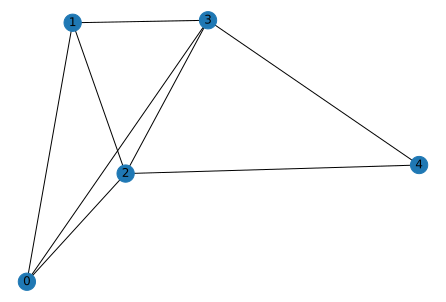

In [2]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [3]:
def initialization(circ):
    for i in range(circ.N):
        circ.apply_gate('H',i,gate_round=0)
    return circ

In [4]:
def cost_unitary(circ,gamma,gate_round):
    for edge in graph:
        circ.apply_gate('RZZ', edge[2]*gamma,edge[0], edge[1], gate_round=gate_round)
    return circ

In [5]:
def mixture_unitary(circ,alpha,gate_round):
    for i in range(circ.N):
        circ.apply_gate('RX', alpha, i, gate_round=gate_round)
    return circ

In [6]:
def anasatz(gammas, alphas, n_layers,n_nodes):
    N = n_nodes
    circ = qtn.CircuitMPS(N)
    circ = initialization(circ)
    for i in range(n_layers):
        circ = cost_unitary(circ,gammas[i],gate_round=i)
        circ = mixture_unitary(circ,alphas[i],gate_round=i)
    return circ

In [7]:
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

In [8]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
    
)

C:\Users\EXPERT\anaconda3\lib\site-packages\cotengra\hyper.py:20: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [35]:
def cost_function(params):
    gammas, alphas = create_params(params)
    p = int(len(gammas))
    circ = anasatz(gammas, alphas, p,n)
    cost = 0
    ZZ = qu.pauli('Z') & qu.pauli('Z')
    expns = [circ.local_expectation(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    cost = 0.5*(sum(expns).real)
    return cost

In [10]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective
import tqdm

In [11]:
def create_bitstrings(opt_params):
    opt_gammas, opt_alphas = create_params(opt_params)
    opt_circ = anasatz(opt_gammas, opt_alphas, p,n)
    bitstrings = Counter(opt_circ.sample(1000))
    return bitstrings

def get_approximation_ratio(z,b):
    c_z = 0
    c_z_max = 0
    z_a =array_of_key(z)
    for edge in graph:
        c_z = c_z + edge[2]*(1/2)*(1-((1-2*z_a[edge[0]])*(1-2*z_a[edge[1]])))
    for edge in graph:
        c_z_max = c_z_max + edge[2]*(1/2)*(1-((1-2*b[edge[0]])*(1-2*b[edge[1]])))
    app_ratio = c_z / c_z_max
    return app_ratio

def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    return z, maximum

def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold

In [12]:
N = 5
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]
    
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
b = xbest_brute


Best solution = [0, 0, 1, 1, 0] cost = 24.0


In [13]:
def first_guess_linear(n_layers, m1 = 0.5, m2 = 0.5):
    theta = np.zeros([2*n_layers])
    for i in range(2*n_layers):
        if i%2 == 0:
            theta[i] = m1*(i+1) / (2*n_layers)
        else:
            theta[i] = m2*(2*n_layers-i) / (2*n_layers)
    return (theta)

In [60]:
from scipy.optimize import minimize
ZZ = qu.pauli('Z') & qu.pauli('Z')
n=n_nodes
data_final = pd.DataFrame(columns=[["inital angles" ,  "optimal angles", "opt obj value","p", "optimizer"
                                    ,"ground prob",  "approx ratio"]])
rehss = []
#trees = []
#flops = []
widths = []
contraction_costs = []
theta = []
for p in range(1,11):
    print('layer :', p)
    
    if len(theta) == 0:
        theta = first_guess_linear(1, m1 = 0.5, m2 = 0.5)
        
        
    init_params = theta
    print("Initial guess :", init_params)
    gammas, alphas = create_params(init_params)
    circ = anasatz(gammas, alphas, p,n)
    local_exp_rehs = [circ.local_expectation_rehearse(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    edge_wise_rehs = []
    #edge_wise_trees = []
    #edge_wise_flops = []
    edge_wise_widths = []
    edge_wise_contraction_costs = []
    for rehs in local_exp_rehs:
        edge_wise_rehs.append(rehs)
        edge_wise_widths.append(rehs['W'])
        edge_wise_contraction_costs.append(rehs['C'])
        #tree = ctg.ContractionTree.from_info(rehs['info'])
        #edge_wise_trees.append(tree)
        #edge_wise_flops.append(tree.total_flops())
        
    rehss.append(edge_wise_rehs)
    #trees.append(edge_wise_trees)
    #flops.append(edge_wise_flops)
    widths.append(edge_wise_widths)
    contraction_costs.append(edge_wise_contraction_costs)
    
    
    method = "COBYLA"
    out = minimize(cost_function, x0=init_params, method=method, options={'maxiter':100})
        
    
    
    bitstrings = create_bitstrings(out.x)
    
    z , maxm = get_maximum_z(bitstrings)
    print("z with maximum frequency: "+str(z))
    r = get_approximation_ratio(z,b)
    print("approxiamation ratio: "+str(r))
    gse = out.fun
    print("gse: "+str(gse))
    print("prob of maxm string: "+str(maxm/1000))
    
    
    
    data = pd.DataFrame([ [init_params], [out.x],[out.fun], [p], [method],[maxm], [r]]) 
    
    data = data.T
    
    data.columns=[["inital angles" ,  "optimal angles", "opt obj value", "p", "optimizer", "ground prob",  "approx ratio"]]

    data_final = data_final.append(data)
    
    theta = list(out.x)
    for i in range(2):
        theta.append(0)

layer : 1
Initial guess : [0.25 0.25]
z with maximum frequency: 11000
approxiamation ratio: 0.9166666666666666
gse: -4.894870369380923
prob of maxm string: 0.1
layer : 2
Initial guess : [0.21310632383909095, 1.3432024893272754, 0, 0]
z with maximum frequency: 00110
approxiamation ratio: 1.0
gse: -5.081054551180714
prob of maxm string: 0.108
layer : 3
Initial guess : [0.2137517172472263, 1.3379183775483083, 0.9718986556265568, -0.05050575407402066, 0, 0]
z with maximum frequency: 11000
approxiamation ratio: 0.9166666666666666
gse: -5.616756139466365
prob of maxm string: 0.113
layer : 4
Initial guess : [0.21707700225984042, 1.3712663845814772, 0.9480399671706513, -0.12341429188014308, -0.0013344372201453169, -0.06603376353547624, 0, 0]
z with maximum frequency: 11001
approxiamation ratio: 1.0
gse: -5.805178208024159
prob of maxm string: 0.135
layer : 5
Initial guess : [0.21764412230363092, 1.3696552409162426, 0.9455366287306868, -0.14481647241473525, 0.0018838296243656, -0.10719633508146

In [61]:
def plot_histo(data_final, y, optimizer):
    df = pd.DataFrame(np.array(data_final[y].values))
    df.columns = ['a']
    df.index += 1
    df = df.T
    df.columns = ["p_"+str(i) for i in range(1,11)]
    df['optimizer'] = [optimizer]
    print (df)
    solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
    titanic = sns.load_dataset("titanic")
    sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)
    
def plot_line_graph(y):
    #plt.figure(figsize=(10,7))
    x = np.array(range(1,11))
   
    plt.plot(x,y, "-o")
   
    #plt.legend(["COBYLA", "Nelder-Mead", "BFGS"], loc ="lower right")
    plt.xlabel("layers")
    plt.ylabel(y)
    plt.show()

approx ratio
        p_1  p_2       p_3  p_4       p_5  p_6  p_7  p_8  p_9 p_10 optimizer
a  0.916667  1.0  0.916667  1.0  0.916667  1.0  1.0  1.0  1.0  1.0    COBYLA


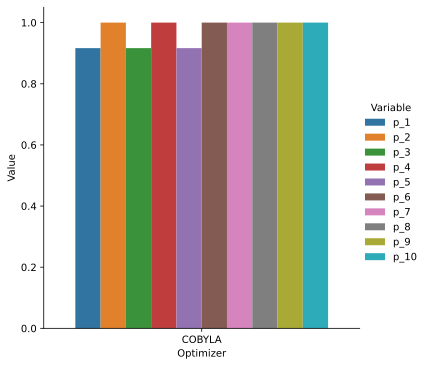

In [62]:
op = method
y = "approx ratio"
print("approx ratio")
plot_histo(data_final, y, op)

ground state
       p_1       p_2       p_3       p_4       p_5       p_6       p_7  \
a -4.89487 -5.081055 -5.616756 -5.805178 -5.988133 -6.281269 -6.749141   

        p_8      p_9      p_10 optimizer  
a -6.944925 -7.14562 -7.236437    COBYLA  


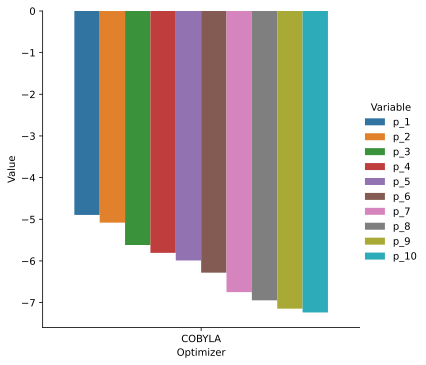

In [63]:
print("ground state")
y = "opt obj value"
plot_histo(data_final, y, op)

Frequency of the optimal bitstring
   p_1  p_2  p_3  p_4  p_5  p_6  p_7  p_8  p_9 p_10 optimizer
a  100  108  113  135  143  162  188  181  229  226    COBYLA


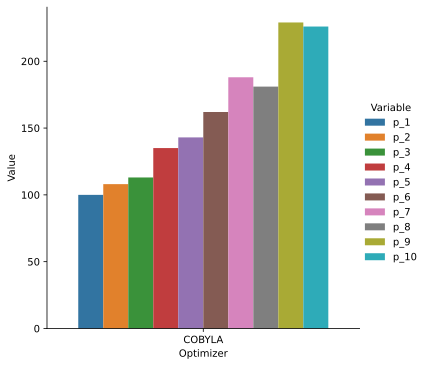

In [64]:
print("Frequency of the optimal bitstring")
y = "ground prob"
plot_histo(data_final, y, op)

In [65]:
data_final

,inital angles,optimal angles,opt obj value,p,optimizer,ground prob,approx ratio
0,"[0.25, 0.25]","[0.21310632383909095, 1.3432024893272754]",-4.89487,1,COBYLA,100,0.916667
0,"[0.21310632383909095, 1.3432024893272754, 0, 0]","[0.2137517172472263, 1.3379183775483083, 0.971...",-5.081055,2,COBYLA,108,1.0
0,"[0.2137517172472263, 1.3379183775483083, 0.971...","[0.21707700225984042, 1.3712663845814772, 0.94...",-5.616756,3,COBYLA,113,0.916667
0,"[0.21707700225984042, 1.3712663845814772, 0.94...","[0.21764412230363092, 1.3696552409162426, 0.94...",-5.805178,4,COBYLA,135,1.0
0,"[0.21764412230363092, 1.3696552409162426, 0.94...","[0.21897375031089814, 1.418837376767452, 0.953...",-5.988133,5,COBYLA,143,0.916667
0,"[0.21897375031089814, 1.418837376767452, 0.953...","[0.21839973788245365, 1.3928237746798617, 0.95...",-6.281269,6,COBYLA,162,1.0
0,"[0.21839973788245365, 1.3928237746798617, 0.95...","[0.22140830398380118, 1.3421427362887992, 0.95...",-6.749141,7,COBYLA,188,1.0
0,"[0.22140830398380118, 1.3421427362887992, 0.95...","[0.21816472230159922, 1.353298053796713, 0.955...",-6.944925,8,COBYLA,181,1.0
0,"[0.21816472230159922, 1.353298053796713, 0.955...","[0.22323969763110968, 1.3584985905473086, 0.95...",-7.14562,9,COBYLA,229,1.0
0,"[0.22323969763110968, 1.3584985905473086, 0.95...","[0.22191761171117227, 1.3485740393427073, 0.95...",-7.236437,10,COBYLA,226,1.0


In [66]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [67]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [68]:
qubitOp, offset = max_cut.get_operator(A)
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, A))

energy: -10.0
max-cut objective: -24.0
solution: [0 0 1 1 0]
solution objective: 24.0


C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\applications\ising\max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\minimum_eigen_solvers\minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.

        p_1       p_2       p_3       p_4       p_5       p_6       p_7  \
a  0.489487  0.508105  0.561676  0.580518  0.598813  0.628127  0.674914   

        p_8       p_9      p_10 optimizer  
a  0.694492  0.714562  0.723644     skopt  


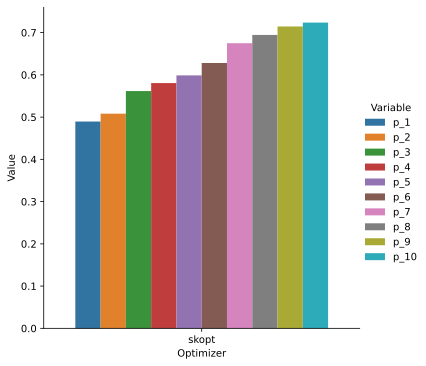

In [69]:
y = "opt obj value"
optimizer = "skopt"
df = pd.DataFrame(np.array(data_final[y].values/result.eigenvalue.real))
df.columns = ['a']
df.index += 1
df = df.T
df.columns = ["p_"+str(i) for i in range(1,11)]
df['optimizer'] = [optimizer]
print (df)
solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
titanic = sns.load_dataset("titanic")
sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)